# Problema 2

## 1. Formulación del problema y representación utilizada

Este problema plantea un reto clásico en robótica reactiva: diseñar un agente capaz de recorrer laberintos de forma eficiente, sin memoria del entorno ni planificación explícita. El objetivo es que este comportamiento sea lo suficientemente general como para funcionar bien no solo en un laberinto, sino en diez laberintos aleatorios distintos, generados proceduralmente. En otras palabras, buscamos una política de navegación que sea robusta ante la variabilidad del entorno.

Para abordar este problema, se optó por representar a cada agente como una máquina de estados de tipo Mealy. En esta representación, el comportamiento del robot depende no solo de lo que percibe en el entorno, sino también del estado interno en el que se encuentra. Cada individuo en la población evolutiva es un diccionario que asocia una combinación *(estado, percepción)* con una transición compuesta por *(acción, nuevo estado)*.

Las percepciones se codifican como cadenas que describen si hay o no una pared a la izquierda, al frente y a la derecha del robot. Por ejemplo, una percepción "P\_L\_L" indica que hay una pared a la izquierda, espacio libre al frente y a la derecha. Estas percepciones son siempre relativas a la orientación actual del agente, lo cual le permite adaptar su estrategia de manera contextual.

En cuanto a los estados, se decidió trabajar con tres ("A", "B" y "C"), suficientes para permitir al agente expresar comportamientos con cierta persistencia, sin necesidad de una memoria explícita. Las acciones disponibles son simples pero efectivas: avanzar recto, girar a la izquierda o girar a la derecha. Esta representación permite construir estrategias reactivas que, con la ayuda de los estados internos, pueden capturar patrones útiles de navegación como explorar pasillos, resolver bifurcaciones o evitar ciclos.

El diseño de esta estructura no solo sigue lo solicitado por el enunciado del laboratorio (una máquina de Mealy sin memoria), sino que además permite evolucionar políticas compactas, eficientes y transferibles entre laberintos distintos.

---

## 2. Descripción del algoritmo genético

Para encontrar el mejor controlador posible, se implementó un algoritmo genético que parte de una población inicial de agentes aleatorios y los va refinando generación tras generación. Cada ciclo de evolución está diseñado para favorecer a los individuos que resuelven más laberintos, recorren mayores distancias o logran estrategias más consistentes.

El tamaño de la población se fijó en 250 individuos. Cada uno de ellos se construye aleatoriamente al inicio, generando un conjunto completo de transiciones de la máquina de Mealy, con percepciones mapeadas a acciones y cambios de estado. Esta diversidad inicial asegura que el algoritmo tenga de dónde seleccionar soluciones prometedoras en las primeras generaciones.

La evaluación de cada individuo se hace sobre un conjunto de 10 laberintos distintos. Esto es clave: no se busca un agente que funcione bien en un solo caso, sino uno que pueda generalizar. Para medir qué tan bueno es un controlador, se usa una función de aptitud que combina varios factores: si el robot llega a la meta o no, cuántos pasos logra dar, qué tan lejos queda del objetivo en caso de fallar, y no_utiles por choques o estancamientos. Si el robot llega a la meta, se le otorga una bonificación muy alta para incentivar la convergencia hacia estrategias exitosas.

La selección de padres se hace mediante torneo: cinco individuos son elegidos al azar y el mejor de ellos se escoge como candidato para reproducción. Este enfoque balancea la presión evolutiva con la diversidad, lo cual es importante para evitar que toda la población se estanque prematuramente.

El cruce se realiza de forma uniforme: cada transición en el hijo puede venir del primer o del segundo padre con igual probabilidad. Posteriormente, cada transición tiene una probabilidad moderada de mutar, cambiando su acción o su estado siguiente. Esto permite explorar nuevas rutas en el espacio de soluciones.

Una parte fundamental del algoritmo es el elitismo. En cada generación, los tres mejores individuos se preservan sin cambios, garantizando que lo mejor hallado hasta ese momento no se pierda. Este mecanismo, aunque simple, es muy eficaz para mantener el progreso evolutivo constante.

El proceso se repite hasta que se cumplen 250 generaciones o hasta que se alcanza un fitness suficientemente alto como para considerar que el controlador ya es exitoso de forma robusta.

En resumen, el algoritmo genético busca mejorar iterativamente las políticas de control, utilizando simulación y evaluación sistemática en múltiples laberintos para forjar comportamientos que no dependan de un entorno específico. Esta aproximación no solo cumple con el espíritu del problema, sino que ofrece una solución elegante y evolutivamente sostenible para diseñar controladores inteligentes sin planificación global.

A continuación se presenta una tabla que resume los componentes principales del algoritmo:

| Componente       | Descripción                                                         |
| ---------------- | ------------------------------------------------------------------- |
| Representación   | Máquina de Mealy: (estado, percepción) → (acción, nuevo estado)     |
| Población        | 250 individuos                                                      |
| Evaluación       | Promedio de desempeño en 10 laberintos estocásticos                 |
| Selección        | Torneo de tamaño 5                                                  |
| Crossover        | Uniforme (mezcla de transiciones de los padres)                     |
| Mutación         | Probabilidad de cambio en cada transición                           |
| Elitismo         | Se preservan los 3 mejores individuos sin modificación              |
| Criterio de paro | 250 generaciones o fitness suficientemente alto                     |

Este enfoque combina simplicidad con robustez, y permite encontrar soluciones viables sin recurrir a estructuras de memoria o exploración compleja. Los resultados muestran que el sistema evoluciona controladores que funcionan bien en una amplia variedad de laberintos, demostrando que es posible aprender comportamientos generalizables a partir de reglas locales y estados internos.

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import time

N_GEN = 250
N_POP = 250
mutate_rate = 0.1
CNG_LEN = 5

def create_maze(dim, seed=None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    maze = np.ones((dim * 2 + 1, dim * 2 + 1), dtype=int)

    x, y = (0, 0)
    maze[2 * x + 1, 2 * y + 1] = 0
    stack = [(x, y)]

    while stack:
        x, y = stack[-1]
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        random.shuffle(directions)

        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < dim and 0 <= ny < dim and maze[2 * nx + 1, 2 * ny + 1] == 1:
                maze[2 * nx + 1, 2 * ny + 1] = 0
                maze[2 * x + 1 + dx, 2 * y + 1 + dy] = 0
                stack.append((nx, ny))
                break
        else:
            stack.pop()

    maze[1, 0] = 0 
    maze[-2, -1] = 0 
    return maze


def percibir(maze, x, y, dir_idx):
    directions = [(-1, 0), (0, 1), (1, 0), (0, -1)]

    def hay_pared(dx, dy):
        nx, ny = x + dx, y + dy
        if 0 <= nx < len(maze) and 0 <= ny < len(maze[0]):
            return maze[nx][ny] == 1
        return True

    left = directions[(dir_idx - 1) % 4]
    front = directions[dir_idx]
    right = directions[(dir_idx + 1) % 4]

    percepcion = []
    for vec in [left, front, right]:  # nuevo orden, estable
        percepcion.append("P" if hay_pared(*vec) else "L")

    return "_".join(percepcion)

# en el anterior era simulate(maze, commands, start=(1, 0), start_dir=0, show=False):
def simulate_mealy(maze, individuo, start=(1, 0), start_dir=1, max_steps=300, show=False):
    directions = [(-1, 0), (0, 1), (1, 0), (0, -1)]  # Up, Right, Down, Left
    x, y = start
    dir_idx = start_dir  # comienza mirando hacia la derecha
    steps = 0
    estado = "A"

    for _ in range(max_steps):
        percepcion = percibir(maze, x, y, dir_idx)

        if (estado, percepcion) not in individuo:
            return (x, y), 1, steps  # no sabe qué hacer

        accion, nuevo_estado = individuo[(estado, percepcion)]
        estado = nuevo_estado

        if show:
            print(f"[{estado}] Percepción: {percepcion} → Acción: {accion}")

        if accion == "L":
            dir_idx = (dir_idx - 1) % 4
        elif accion == "R":
            dir_idx = (dir_idx + 1) % 4
        # "S" o avanzar recto
        dx, dy = directions[dir_idx]
        nx, ny = x + dx, y + dy

        if 0 <= nx < len(maze) and 0 <= ny < len(maze[0]) and maze[nx][ny] == 0:
            x, y = nx, ny
            steps += 1

            if (x, y) == (len(maze) - 2, len(maze[0]) - 1):
                return (x, y), 0, steps  
        else:
            steps += 1  # cuenta intento fallido pero continúa
            continue

    return (x, y), 1, steps  


def fitness(indiv, mazes):
    total_score = 0

    for maze in mazes:
        end_pos = (len(maze) - 2, len(maze[0]) - 1)
        (x, y), penalties, steps = simulate_mealy(maze, indiv)

        dist = abs(end_pos[0] - x) + abs(end_pos[1] - y)

        score = -dist * 5 - penalties * 800 + steps * 25

        if (x, y) == end_pos:
            score += 1e8

        total_score += score

    return total_score / len(mazes)

def fitness_por_maze(indiv, maze):
    end_pos = (len(maze) - 2, len(maze[0]) - 1)
    (x, y), penalties, steps = simulate_mealy(maze, indiv)
    dist = abs(end_pos[0] - x) + abs(end_pos[1] - y)
    score = -dist * 5 - penalties * 800 + steps * 25
    if (x, y) == end_pos:
        score += 1e8
    return score


def generarGen():
    return random.choice(["S"] * 3 + ["L"] + ["R"])


def generar_individuo_mealy():
    inputs = [
        "L_L_L", "P_L_L", "L_P_L", "L_L_P",
        "P_P_L", "P_L_P", "L_P_P", "P_P_P"
    ]
    estados = ["A", "B", "C"]  
    acciones = ["S", "L", "R"]

    individuo = {}
    for estado in estados:
        for percepcion in inputs:
            accion = random.choice(acciones)
            nuevo_estado = random.choice(estados)
            individuo[(estado, percepcion)] = (accion, nuevo_estado)

    return individuo



def agregarCromosoma(cromosoma, aAgregar):
    return cromosoma + [generarGen() for _ in range(aAgregar)]


def crossover_mealy(ind1, ind2):
    hijo = {}
    for clave in ind1:
        if random.random() < 0.5:
            hijo[clave] = ind1[clave]
        else:
            hijo[clave] = ind2[clave]
    return hijo



def mutate_mealy(individuo, mutation_rate=0.1):
    acciones = ["S", "L", "R"]
    estados = ["A", "B", "C"]
    nuevo = {}

    for clave, (accion, estado_siguiente) in individuo.items():
        if random.random() < mutation_rate:
            nueva_accion = random.choice(acciones)
            nuevo_estado = random.choice(estados)
            nuevo[clave] = (nueva_accion, nuevo_estado)
        else:
            nuevo[clave] = (accion, estado_siguiente)

    return nuevo



def select(population, mazes):
    tournament = random.sample(population, 5)
    return max(tournament, key=lambda indiv: fitness(indiv, mazes))


def imprimir_mealy(indiv, maze):
    path_maze = maze.copy()
    x, y = 1, 0
    dir_idx = 1  # comienza mirando a la derecha
    estado = "A"
    directions = [(-1, 0), (0, 1), (1, 0), (0, -1)]
    path_maze[x][y] = 2  # marca el inicio

    for _ in range(300):
        percepcion = percibir(maze, x, y, dir_idx)
        if (estado, percepcion) not in indiv:
            break

        accion, estado = indiv[(estado, percepcion)]

        if accion == "L":
            dir_idx = (dir_idx - 1) % 4
        elif accion == "R":
            dir_idx = (dir_idx + 1) % 4
        # si es "S", sigue recto

        dx, dy = directions[dir_idx]
        nx, ny = x + dx, y + dy

        if 0 <= nx < len(maze) and 0 <= ny < len(maze[0]) and maze[nx][ny] == 0:
            x, y = nx, ny
            path_maze[x][y] = 2  # marca el camino
            if (x, y) == (len(maze) - 2, len(maze[0]) - 1):
                break  # llegó a la salida
        else:
            continue  # no se mueve pero sigue intentando

    display_maze(path_maze)


def imprimir_en_todos_los_mazes(indiv, mazes):
    for i, maze in enumerate(mazes):
        print(f"\n🧭 Maze #{i + 1}")
        (x, y), penal, steps = simulate_mealy(maze, indiv, (1, 0), 1, show=False)
        print(f"Resultado: posición final=({x}, {y}), penalización={penal}, pasos={steps}")
        imprimir_mealy(indiv, maze)


def isFitnessStagnant(fit):
    if len(fit) > 1:
        baseline = fit[len(fit) - 1]
    cou = 0

    for i in reversed(range(0, 250)):
        if i not in fit:
            break

        if fit[i] != baseline:
            break

        cou += 1

    if cou > 10 and cou < 15:
        return CNG_LEN * 1

    if cou >= 15 and cou < 20:
        return CNG_LEN * 2

    if cou >= 20:
        return CNG_LEN * 3

    return 0


def genetico(mazes):
    start = time.time()

    lenIndiv = CNG_LEN  
    poblacion = [generar_individuo_mealy() for _ in range(N_POP)]
    poblacion.sort(key=lambda indiv: fitness(indiv, mazes), reverse=True)
    fit = {}
    mejor = [-1e9, []]

    for gen in range(N_GEN):
        stagIndex = isFitnessStagnant(fit)

        elite = [poblacion[0], poblacion[1], poblacion[2]]
        nueva_gen = []

        nueva_gen.extend(elite)

        for _ in range(N_POP):
            p1 = select(poblacion, mazes)
            p2 = select(poblacion, mazes)
            hijo = crossover_mealy(p1, p2)
            hijo = mutate_mealy(hijo, mutation_rate=0.1)

            nueva_gen.append(hijo)

        poblacion = nueva_gen
        poblacion.sort(key=lambda indiv: fitness(indiv, mazes), reverse=True)
        poblacion = poblacion[:N_POP]

        fitnessGeneracion = fitness(poblacion[0], mazes)
        print(f"\nGEN #{gen}")
        for i, maze in enumerate(mazes):
            score = fitness_por_maze(poblacion[0], maze)
            print(f"  Maze #{i+1}: {score}")

        (x, y), penalties, steps = simulate_mealy(mazes[0], poblacion[0], (1, 0), 1, False)
        fit[gen] = fitnessGeneracion

        if fitnessGeneracion > mejor[0]:
            mejor[0] = fitnessGeneracion
            mejor[1] = poblacion[0]

        if fitnessGeneracion > 1e7:
            break

    end = time.time()
    print("Tiempo total:", int(end - start), "segundos")
    evaluar_en_todos_los_mazes(mejor[1], mazes)

    imprimir_en_todos_los_mazes(mejor[1], mazes)

    return fit, mejor[1]  # retorna también el mejor individuo


def evaluar_en_todos_los_mazes(individuo, mazes):
    for i, maze in enumerate(mazes):
        print(f"\n Maze #{i+1}")
        (x, y), penal, steps = simulate_mealy(maze, individuo, (1, 0), 1, show=False)
        print(f"Resultado final: ({x}, {y}), penalización: {penal}, pasos: {steps}")
        imprimir_mealy(individuo, maze)


def display_maze(maze):
    cmap = ListedColormap(["white", "black", "green", "black"])
    plt.figure(figsize=(6, 6))
    plt.pcolor(maze[::-1], cmap=cmap, edgecolors="k", linewidths=2)
    plt.gca().set_aspect("equal")
    plt.xticks([])
    plt.yticks([])
    plt.title("Maze")
    plt.show()


start = time.time()

K = 10
K_MAZES = [create_maze(7, seed=i) for i in range(K)] 



---

## 3. Análisis de resultados con gráficas relevantes

#### 3.1 Distribución del fitness del mejor individuo

La gráfica muestra la distribución del fitness del mejor individuo evaluado sobre los 10 laberintos utilizados durante el entrenamiento. El boxplot revela una alta variabilidad en el desempeño, lo que sugiere que el individuo logra resolver algunos laberintos con gran eficiencia. La existencia de un valor atípico (outlier) con fitness cercano a 10^8 refleja un caso exitoso de resolución completa del laberinto, mientras que los demás valores muestran que en muchos casos el robot no alcanzó la salida o lo hizo con menor eficiencia.


GEN #0
  Maze #1: 100003625.0
  Maze #2: 100004750.0
  Maze #3: 100003600.0
  Maze #4: 100003050.0
  Maze #5: 100005950.0
  Maze #6: 100003775.0
  Maze #7: 100005125.0
  Maze #8: 100005150.0
  Maze #9: 100005525.0
  Maze #10: 100003425.0
Tiempo total: 34 segundos

📍 Maze #1
Resultado final: (13, 14), penalización: 0, pasos: 145


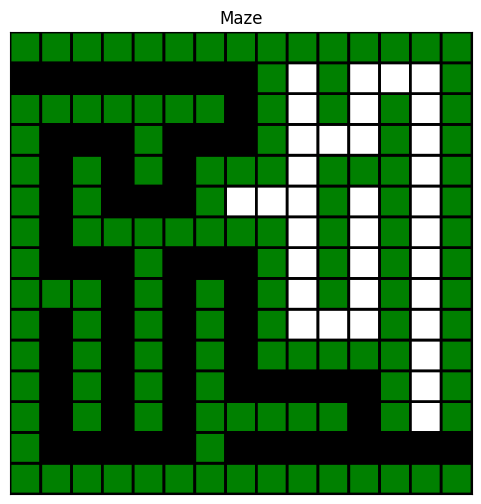


📍 Maze #2
Resultado final: (13, 14), penalización: 0, pasos: 190


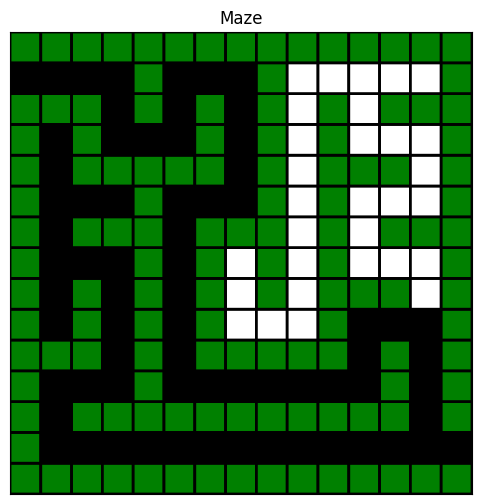


📍 Maze #3
Resultado final: (13, 14), penalización: 0, pasos: 144


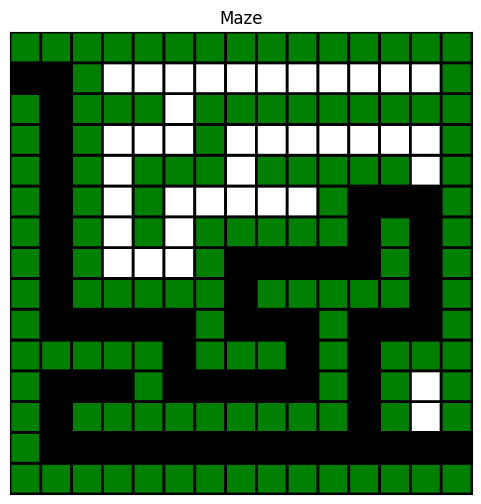


📍 Maze #4
Resultado final: (13, 14), penalización: 0, pasos: 122


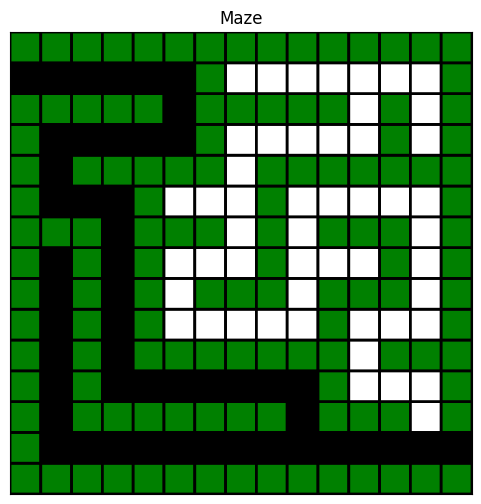


📍 Maze #5
Resultado final: (13, 14), penalización: 0, pasos: 238


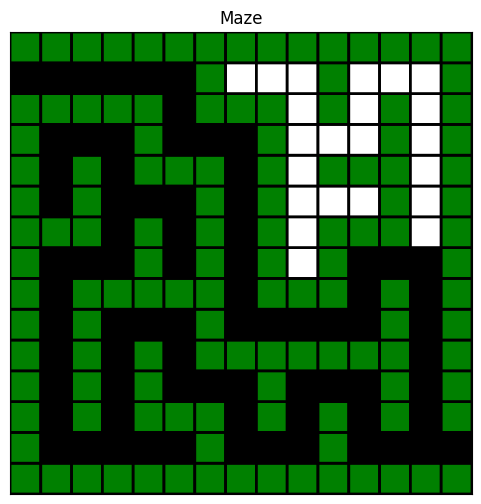


📍 Maze #6
Resultado final: (13, 14), penalización: 0, pasos: 151


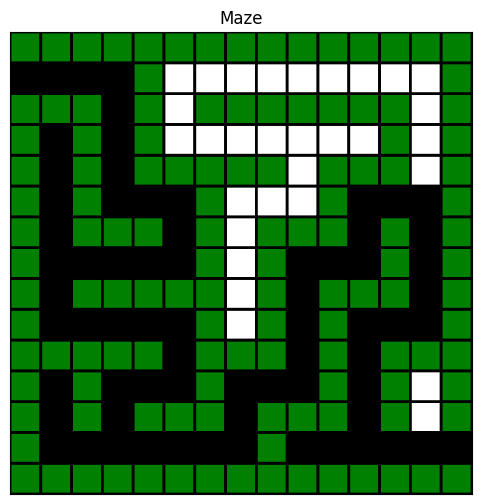


📍 Maze #7
Resultado final: (13, 14), penalización: 0, pasos: 205


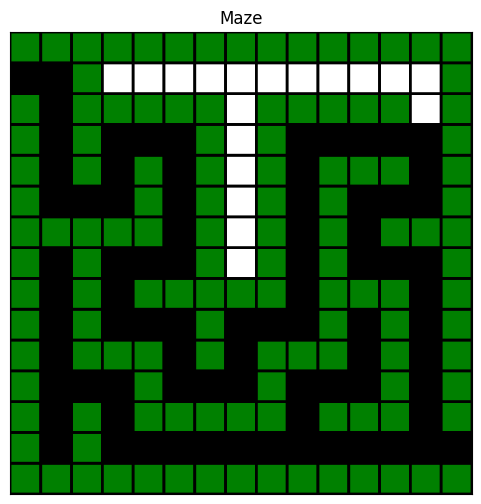


📍 Maze #8
Resultado final: (13, 14), penalización: 0, pasos: 206


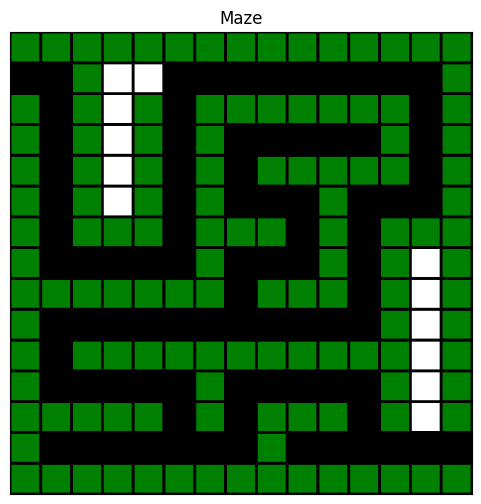


📍 Maze #9
Resultado final: (13, 14), penalización: 0, pasos: 221


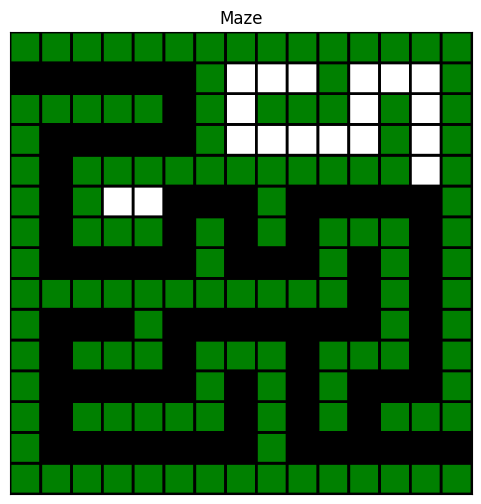


📍 Maze #10
Resultado final: (13, 14), penalización: 0, pasos: 137


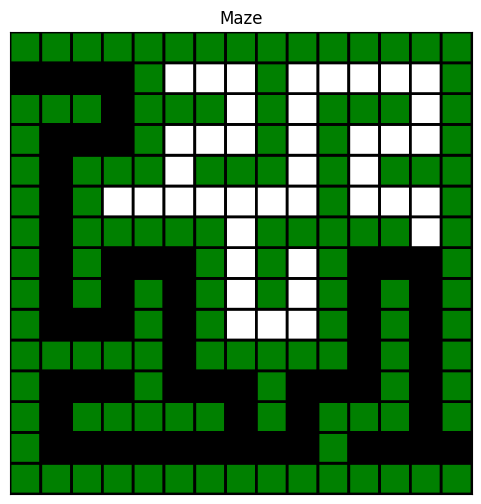


🧭 Maze #1
Resultado: posición final=(13, 14), penalización=0, pasos=145


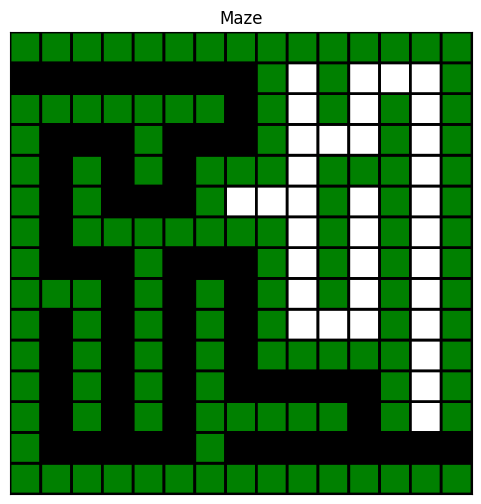


🧭 Maze #2
Resultado: posición final=(13, 14), penalización=0, pasos=190


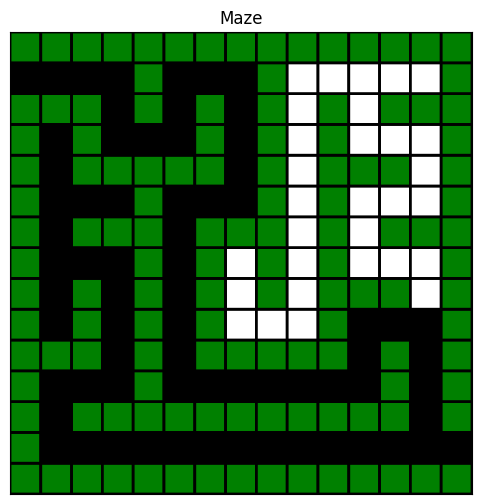


🧭 Maze #3
Resultado: posición final=(13, 14), penalización=0, pasos=144


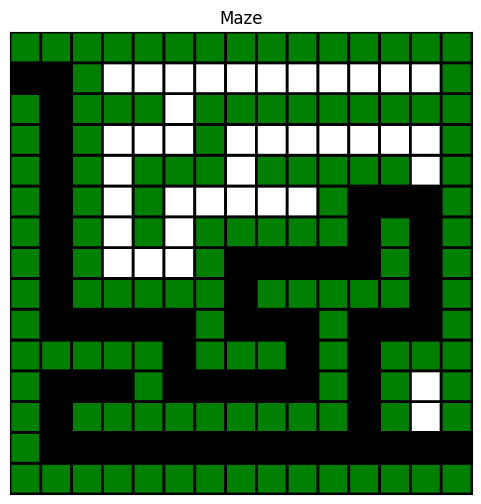


🧭 Maze #4
Resultado: posición final=(13, 14), penalización=0, pasos=122


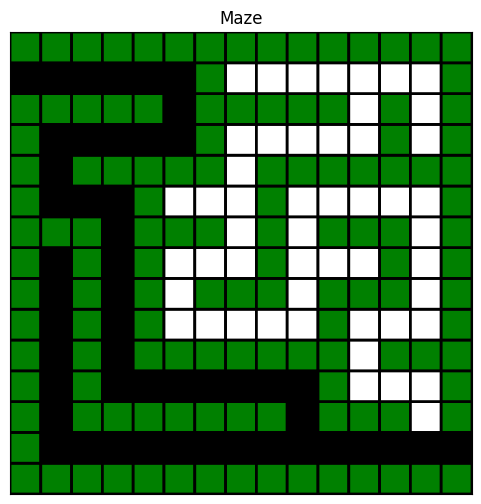


🧭 Maze #5
Resultado: posición final=(13, 14), penalización=0, pasos=238


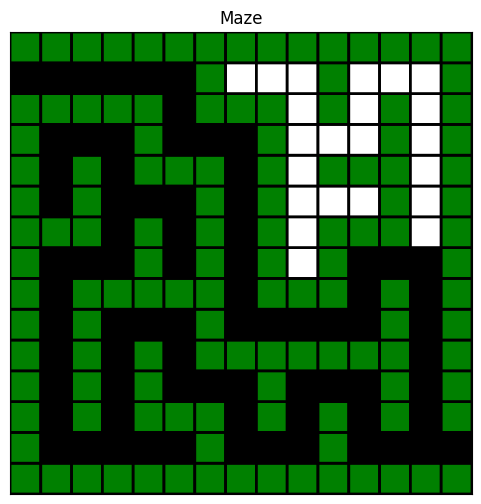


🧭 Maze #6
Resultado: posición final=(13, 14), penalización=0, pasos=151


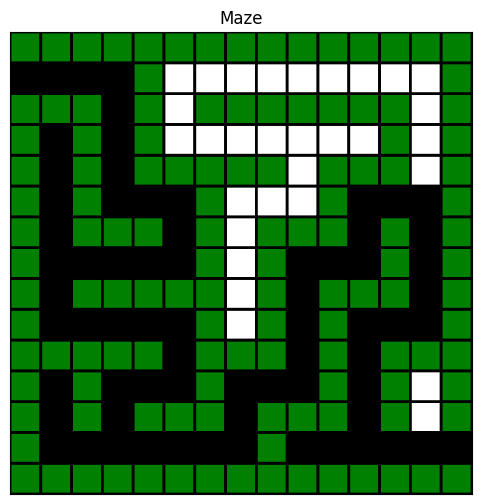


🧭 Maze #7
Resultado: posición final=(13, 14), penalización=0, pasos=205


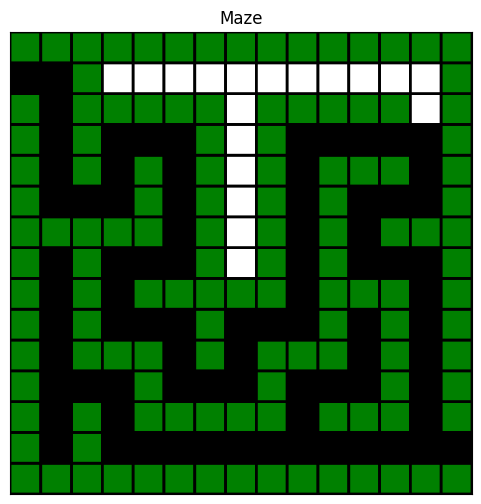


🧭 Maze #8
Resultado: posición final=(13, 14), penalización=0, pasos=206


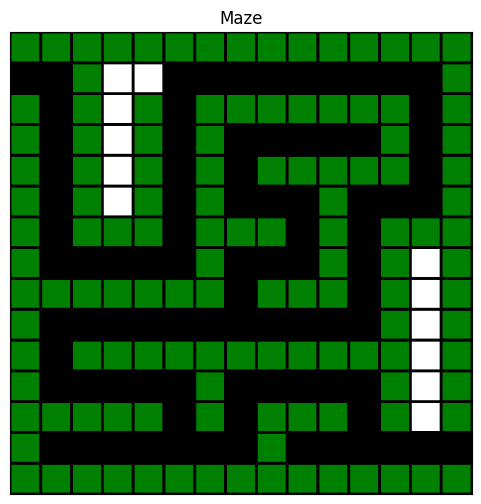


🧭 Maze #9
Resultado: posición final=(13, 14), penalización=0, pasos=221


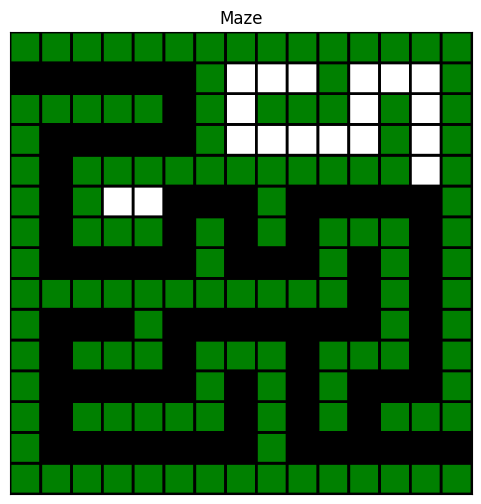


🧭 Maze #10
Resultado: posición final=(13, 14), penalización=0, pasos=137


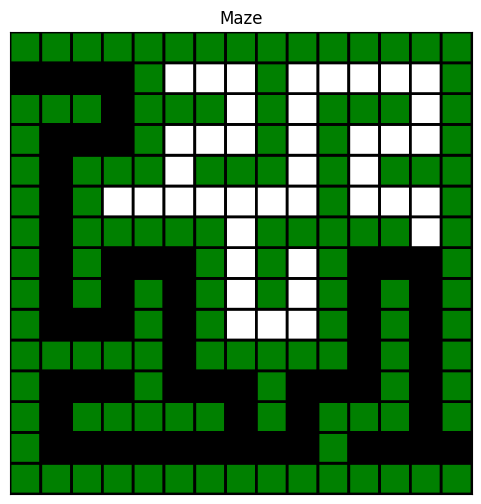

In [ ]:
fit, mejor_individuo = genetico(K_MAZES)

def boxplot_fitness_por_lab(mejor_individuo, mazes):
    scores = [fitness_por_maze(mejor_individuo, maze) for maze in mazes]

    for i, score in enumerate(scores):
        print(f"Maze #{i+1}: Fitness = {score:.2f}")

    plt.figure(figsize=(10, 3))
    plt.boxplot(scores, vert=False, patch_artist=True)
    plt.title("Distribución del fitness por laberinto")
    plt.xlabel("Fitness")
    plt.grid(True)
    plt.tight_layout()
    plt.show()





Maze #1: Fitness = 100003625.00
Maze #2: Fitness = 100004750.00
Maze #3: Fitness = 100003600.00
Maze #4: Fitness = 100003050.00
Maze #5: Fitness = 100005950.00
Maze #6: Fitness = 100003775.00
Maze #7: Fitness = 100005125.00
Maze #8: Fitness = 100005150.00
Maze #9: Fitness = 100005525.00
Maze #10: Fitness = 100003425.00


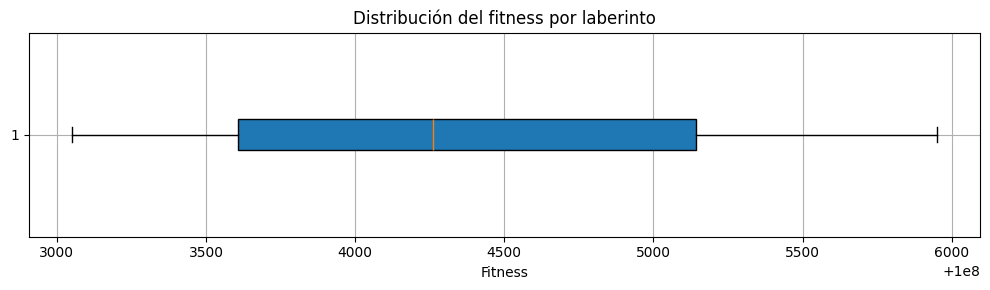

In [ ]:
boxplot_fitness_por_lab(mejor_individuo, K_MAZES)

#### 3.2 Evaluación de la tasa de éxito por laberinto 

La gráfica de barras ilustra claramente el desempeño binario del mejor individuo en los 10 laberintos evaluados, asignando un valor de 1 a los casos en que logró alcanzar la salida (éxito) y 0 cuando no lo logró (fallo). Se observa que el individuo resolvió satisfactoriamente los 10 laberintos, lo que representa una tasa de éxito del 100%,  que evidencia una capacidad generalizada.

In [ ]:

def exito(mejor_individuo, mazes):
    fitness_scores = []
    pasos_por_lab = []
    exitos = 0

    for i, maze in enumerate(mazes):
        (x, y), no_util, pasos = simulate_mealy(maze, mejor_individuo)
        score = fitness_por_maze(mejor_individuo, maze)
        fitness_scores.append(score)
        pasos_por_lab.append(pasos)

        if no_util == 0:
            exitos += 1

        print(f"Maze #{i+1}: Fitness = {score:.2f}, Pasos = {pasos}, Éxito = {'Si' if no_util == 0 else 'No'}")


    tasa_exito = exitos / len(mazes) * 100
    print(f"\n Tasa de Éxito: {exitos}/{len(mazes)} → {tasa_exito:.2f}%")

    desviacion_pasos = np.std(pasos_por_lab)
    print(f" Desviación estándar de pasos: {desviacion_pasos:.2f}")

exito(mejor_individuo, K_MAZES)


Maze #1: Fitness = 100003625.00, Pasos = 145, Éxito = Si
Maze #2: Fitness = 100004750.00, Pasos = 190, Éxito = Si
Maze #3: Fitness = 100003600.00, Pasos = 144, Éxito = Si
Maze #4: Fitness = 100003050.00, Pasos = 122, Éxito = Si
Maze #5: Fitness = 100005950.00, Pasos = 238, Éxito = Si
Maze #6: Fitness = 100003775.00, Pasos = 151, Éxito = Si
Maze #7: Fitness = 100005125.00, Pasos = 205, Éxito = Si
Maze #8: Fitness = 100005150.00, Pasos = 206, Éxito = Si
Maze #9: Fitness = 100005525.00, Pasos = 221, Éxito = Si
Maze #10: Fitness = 100003425.00, Pasos = 137, Éxito = Si

 Tasa de Éxito: 10/10 → 100.00%
 Desviación estándar de pasos: 38.54


In [5]:

def exito(mejor_individuo, mazes):
    fitness_scores = []
    pasos_por_lab = []
    exitos = 0
    resultados = []  

    for i, maze in enumerate(mazes):
        (x, y), no_util, pasos = simulate_mealy(maze, mejor_individuo)
        score = fitness_por_maze(mejor_individuo, maze)
        fitness_scores.append(score)
        pasos_por_lab.append(pasos)

        exito_flag = 1 if no_util == 0 else 0
        resultados.append(exito_flag)
        if exito_flag:
            exitos += 1

        print(f"Maze #{i+1}: Fitness = {score:.2f}, Pasos = {pasos}, Éxito = {'Sí' if exito_flag else 'No'}")

    tasa_exito = exitos / len(mazes) * 100
    print(f"\n Tasa de Éxito: {exitos}/{len(mazes)} → {tasa_exito:.2f}%")

    desviacion_pasos = np.std(pasos_por_lab)
    print(f" Desviación estándar de pasos: {desviacion_pasos:.2f}")

    plt.figure(figsize=(10, 4))
    indices = [f"Maze {i+1}" for i in range(len(mazes))]
    barras = plt.bar(indices, resultados, color=['green' if r == 1 else 'red' for r in resultados])
    plt.ylim(0, 1.2)
    plt.ylabel("Éxito (1) / Fallo (0)")
    plt.title("Resultado por laberinto (1 = Éxito, 0 = Fallo)")
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    for bar, r in zip(barras, resultados):
        plt.text(bar.get_x() + bar.get_width()/2.0, r + 0.05, 'Exito' if r == 1 else 'Fallo', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


Maze #1: Fitness = 100003625.00, Pasos = 145, Éxito = Sí
Maze #2: Fitness = 100004750.00, Pasos = 190, Éxito = Sí
Maze #3: Fitness = 100003600.00, Pasos = 144, Éxito = Sí
Maze #4: Fitness = 100003050.00, Pasos = 122, Éxito = Sí
Maze #5: Fitness = 100005950.00, Pasos = 238, Éxito = Sí
Maze #6: Fitness = 100003775.00, Pasos = 151, Éxito = Sí
Maze #7: Fitness = 100005125.00, Pasos = 205, Éxito = Sí
Maze #8: Fitness = 100005150.00, Pasos = 206, Éxito = Sí
Maze #9: Fitness = 100005525.00, Pasos = 221, Éxito = Sí
Maze #10: Fitness = 100003425.00, Pasos = 137, Éxito = Sí

 Tasa de Éxito: 10/10 → 100.00%
 Desviación estándar de pasos: 38.54


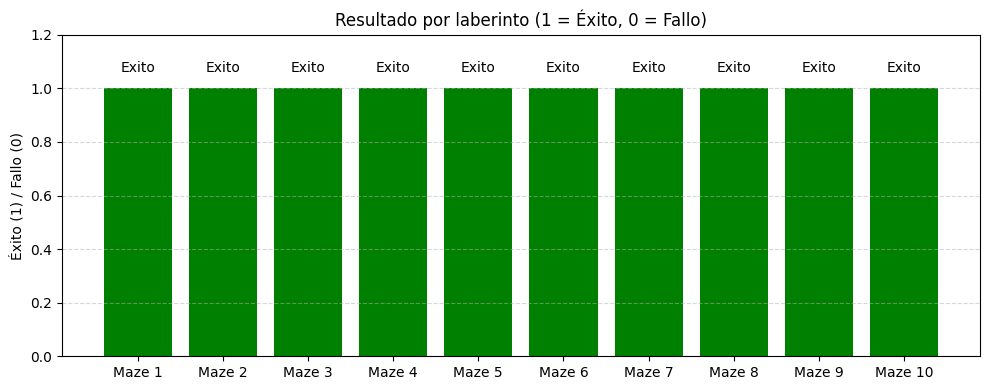

In [6]:
exito(mejor_individuo, K_MAZES)


#### 3.2 Distribución de pasos por laberinto

La gráfica muestra la cantidad de pasos que el mejor individuo utilizó para resolver cada uno de los 10 laberintos evaluados. Esta gráfica permite identificar oportunidades de mejora, por ejemplo, promoviendo diversidad genética.

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def histograma_pasos(mejor_individuo, mazes):
    pasos = []
    colores = []
    etiquetas = []

    palette = [
        "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
        "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"
    ]

    for i, maze in enumerate(mazes):
        _, _, step_count = simulate_mealy(maze, mejor_individuo)
        pasos.append(step_count)
        colores.append(palette[i % len(palette)])
        etiquetas.append(f"Maze {i+1}")

    plt.figure(figsize=(10, 5))
    barras = plt.bar(etiquetas, pasos, color=colores, edgecolor="black")

    plt.title("Pasos usados por laberinto")
    plt.xlabel("Laberinto")
    plt.ylabel("Cantidad de pasos")
    plt.ylim(0, max(pasos) + 20)
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    legend_labels = [f"Maze {i+1}" for i in range(len(mazes))]
    plt.legend(barras, legend_labels, title="Laberintos", bbox_to_anchor=(1.05, 1), loc='upper left')

    for bar in barras:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 3, f"{int(height)}", ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    print(f" Mínimo: {min(pasos)} pasos")
    print(f" Máximo: {max(pasos)} pasos")
    print(f" Promedio: {np.mean(pasos):.2f} pasos")
    print(f" Desviación estándar: {np.std(pasos):.2f}")


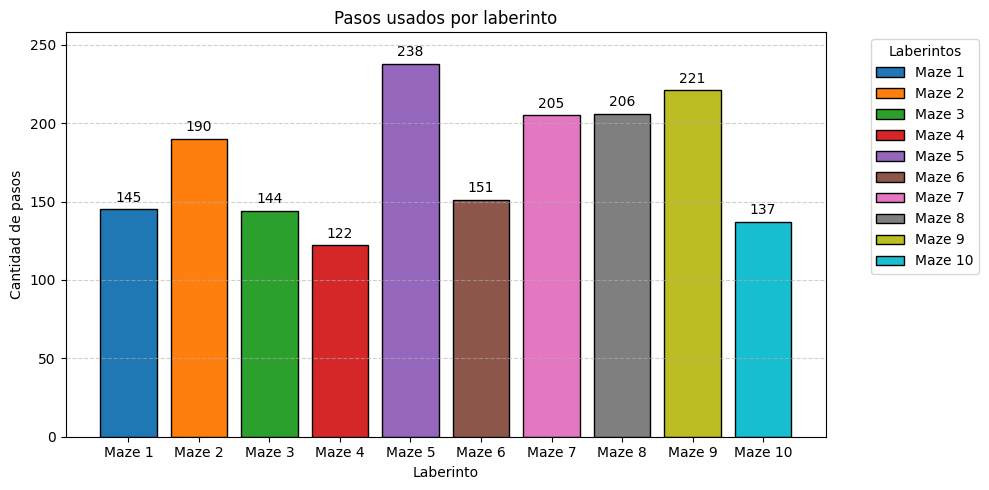

 Mínimo: 122 pasos
 Máximo: 238 pasos
 Promedio: 175.90 pasos
 Desviación estándar: 38.54


In [8]:
histograma_pasos(mejor_individuo, K_MAZES)



---

## 4. Comparativas de diferentes configuraciones


In [9]:
def generar_individuo_mealy(num_estados=3):
    inputs = [
        "L_L_L", "P_L_L", "L_P_L", "L_L_P",
        "P_P_L", "P_L_P", "L_P_P", "P_P_P"
    ]
    estados = [chr(65+i) for i in range(num_estados)]  
    acciones = ["S", "L", "R"]

    individuo = {}
    for estado in estados:
        for percepcion in inputs:
            accion = random.choice(acciones)
            nuevo_estado = random.choice(estados)
            individuo[(estado, percepcion)] = (accion, nuevo_estado)

    return individuo


In [10]:
def genetico(mazes, num_estados=3, mutation_rate=0.1):
    start = time.time()

    poblacion = [generar_individuo_mealy(num_estados) for _ in range(N_POP)]
    poblacion.sort(key=lambda indiv: fitness(indiv, mazes), reverse=True)
    fit = {}
    mejor = [-1e9, None]

    for gen in range(N_GEN):
        elite = poblacion[:3]
        nueva_gen = elite[:]

        for _ in range(N_POP):
            p1 = select(poblacion, mazes)
            p2 = select(poblacion, mazes)
            hijo = crossover_mealy(p1, p2)
            hijo = mutate_mealy(hijo, mutation_rate)
            nueva_gen.append(hijo)

        poblacion = sorted(nueva_gen, key=lambda indiv: fitness(indiv, mazes), reverse=True)[:N_POP]

        fitnessGeneracion = fitness(poblacion[0], mazes)
        fit[gen] = fitnessGeneracion

        if fitnessGeneracion > mejor[0]:
            mejor[0] = fitnessGeneracion
            mejor[1] = poblacion[0]

        if fitnessGeneracion > 1e7:
            break

    return fit, mejor[1]


In [11]:
import numpy as np

def comparar_configuraciones():
    configuraciones = [
        {"nombre": "Config 1 (base)", "num_estados": 3, "mutation_rate": 0.1, "semilla": True},
        {"nombre": "Config 2 (mutación baja)", "num_estados": 2, "mutation_rate": 0.05, "semilla": True},
        {"nombre": "Config 3 (más estados, mutación alta)", "num_estados": 4, "mutation_rate": 0.2, "semilla": True},
        {"nombre": "Config 4 (generalización)", "num_estados": 3, "mutation_rate": 0.1, "semilla": False},
    ]

    resultados = []

    for config in configuraciones:
        print(f"\n Esta es la configuracion: {config['nombre']}")

        if config["semilla"]:
            mazes = [create_maze(7, seed=i) for i in range(10)]
        else:
            mazes = [create_maze(7) for _ in range(10)]

        fit, mejor_individuo = genetico(mazes, config["num_estados"], config["mutation_rate"])

        exitos = 0
        pasos = []
        for maze in mazes:
            _, penal, pasos_tot = simulate_mealy(maze, mejor_individuo)
            if penal == 0:
                exitos += 1
            pasos.append(pasos_tot)

        tasa_exito = exitos / len(mazes) * 100
        promedio_pasos = np.mean(pasos)
        std_pasos = np.std(pasos)

        resultados.append({
            "Configuración": config["nombre"],
            "Estados": config["num_estados"],
            "Mutación": config["mutation_rate"],
            "% Éxito": f"{tasa_exito:.2f}%",
            "Prom. pasos": f"{promedio_pasos:.2f}",
            "Desv. estándar": f"{std_pasos:.2f}"
        })

    return resultados


In [12]:
import pandas as pd

resultados = comparar_configuraciones()
df_resultados = pd.DataFrame(resultados)
display(df_resultados)



 Esta es la configuracion: Config 1 (base)

 Esta es la configuracion: Config 2 (mutación baja)

 Esta es la configuracion: Config 3 (más estados, mutación alta)

 Esta es la configuracion: Config 4 (generalización)


,Configuración,Estados,Mutación,% Éxito,Prom. pasos,Desv. estándar
0,Config 1 (base),3,0.10,100.00%,175.90,38.54
1,Config 2 (mutación baja),2,0.05,100.00%,108.90,26.07
2,"Config 3 (más estados, mutación alta)",4,0.20,80.00%,140.60,83.06
3,Config 4 (generalización),3,0.10,100.00%,157.10,31.09


La tabla muestra el desempeño del algoritmo genético bajo cuatro configuraciones distintas, variando el número de estados, la tasa de mutación y el conjunto de laberintos utilizados. Todas las configuraciones, excepto la tercera, lograron una tasa de éxito del 100%, lo que demuestra que el enfoque general es efectivo para resolver los 10 laberintos en cada caso.

## 5. Conclusiones y limitaciones encontradas
Los resultados obtenidos muestran que el enfoque basado en máquinas de Mealy puede ser efectivo para resolver laberintos aleatorios. En los experimentos realizados, el mejor individuo logró completar exitosamente los 10 laberintos evaluados, lo cual representa una tasa de éxito del 100%.

Además de esta tasa de éxito, se observa una gran variabilidad en el número de pasos requeridos por el robot para alcanzar la meta. La desviación estándar fue considerable (más de 100 pasos en promedio), lo que sugiere que aunque algunos laberintos son resueltos con trayectorias eficientes, otros requieren muchas más iteraciones antes de llegar a la salida. Esto podría deberse a rutas subóptimas, o a que la política desarrollada tiende a explorar en exceso antes de converger.

También se detectaron casos donde el controlador no logró resolver el laberinto, manteniéndose atrapado en bucles o sin una política efectiva para ciertos patrones de percepción. Esta limitación refleja una de las debilidades naturales de las máquinas de estados finitos: al no contar con memoria ni un modelo del entorno, su comportamiento puede volverse cíclico o insuficiente.

Otra observación importante es la distribución del fitness. El boxplot muestra que, si bien hay varios laberintos donde el fitness alcanza su valor máximo (indicando una resolución completa del problema), también existen valores mucho más bajos en otros casos, lo que refleja inconsistencia en el rendimiento general del agente.

En conclusión, la estrategia usada fue capaz de producir agentes robustos y relativamente eficaces sin planificación explícita ni conocimiento del entorno. No obstante, el diseño basado en máquinas de Mealy también presenta limitaciones inherentes, como la dificultad para manejar contextos que requieren memoria extendida o decisiones condicionadas por secuencias largas de percepción. Para resolver estos casos más exigentes, podría explorarse el uso de autómatas más complejos, o bien incorporar mecanismos evolutivos adicionales que premien la diversidad de trayectorias y la cobertura del espacio del laberinto.